In [1]:
import re

token_pattern = re.compile(r'\d+|[+\-*/()\[\]]')

In [2]:
expr = "6*4-5/(3+7)"

tokens = token_pattern.findall(expr)

tokens

['6', '*', '4', '-', '5', '/', '(', '3', '+', '7', ')']

In [3]:
OPERATORS = {
    '+': 2,
    '-': 2,
    '*': 4,
    '/': 4,
    '^': 6,
}

In [4]:
def precedence(token):
    return OPERATORS[token]

In [5]:
LEFT_BRACKETS = ['(', '[']
RIGHT_BRACKETS = {
    ')': '(',
    ']': '[',
}

In [6]:
def match(left, right):
    return RIGHT_BRACKETS[right] == left

In [7]:
def convert_to_rpn(token_list):
    cursor = 0

    operator_stack = []
    rpn_out = []

    while cursor < len(token_list):
        token = token_list[cursor]
        cursor += 1

        if token in OPERATORS:
            shunting = True

            while shunting:
                if operator_stack == []:
                    shunting = False
                elif operator_stack[-1] in LEFT_BRACKETS:
                    shunting = False
                elif precedence(operator_stack[-1]) > precedence(token):
                    rpn_out.append(operator_stack.pop(-1))
                else:
                    shunting = False

            operator_stack.append(token)

        elif token in LEFT_BRACKETS:
            operator_stack.append(token)

        elif token in RIGHT_BRACKETS:
            shunting = True

            while shunting:
                if operator_stack == []:
                    shunting = False
                else:
                    operator = operator_stack.pop()
                    print(operator)

                    if operator in LEFT_BRACKETS:
                        if match(operator, token):
                            shunting = False
                        else:
                            raise SyntaxError(f'Unmatched brackets: {operator}, {token}')
                    else:
                        rpn_out.append(operator)

        else:
            rpn_out.append(token)

    while operator_stack:
        rpn_out.append(operator_stack.pop())

    return rpn_out

In [8]:
rpn_tokens = convert_to_rpn(tokens)
rpn_tokens

+
(


['6', '4', '*', '5', '3', '7', '+', '/', '-']

In [9]:
import uuid

class Node:
    def __init__(self, token, parent=None, left=None, right=None):
        self.token = token
        self.left = left
        self.right = right
        self.parent = parent
        self.uid = uuid.uuid4()

    def set_left(self, left):
        self.left = left

    def set_right(self, right):
        self.right = right

    def set_parent(self, parent):
        self.parent = parent

    def get_parent(self):
        return self.parent

    def get_left(self):
        return self.left

    def get_right(self):
        return self.right

    def __repr__(self):
        r_string = f'Node({self.token}'
        if self.left:
            r_string += f', {self.left}'
        if self.right:
            r_string += f', {self.right}'

        r_string += ')'

        return r_string

In [10]:
def rpn_to_tree(rpn_tokens):
    cursor = 0
    node_stack = []

    while cursor < len(rpn_tokens):
        token = rpn_tokens[cursor]
        cursor += 1

        if token in OPERATORS:
            next_node = Node(token, right=node_stack.pop(), left=node_stack.pop())

            node_stack.append(next_node)
        else:
            node_stack.append(Node(token))
    return node_stack[0]

In [11]:
tree = rpn_to_tree(rpn_tokens)
tree

Node(-, Node(*, Node(6), Node(4)), Node(/, Node(5), Node(+, Node(3), Node(7))))

In [12]:
import matplotlib.pyplot as plt
import networkx as nx


# Recursive function to add edges to the graph

def add_edges(graph, node, label_dict):
    if node.left:
        graph.add_node(node.left.uid)
        label_dict.update({node.left.uid: node.left.token})

        graph.add_edge(node.uid, node.left.uid)

        add_edges(graph, node.left, label_dict)

    if node.right:
        graph.add_node(node.right.uid)
        label_dict.update({node.right.uid: node.right.token})

        graph.add_edge(node.uid, node.right.uid)

        add_edges(graph, node.right, label_dict)


In [13]:
# Recursive function to place nodes

def hierarchy_pos(G, root, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None):
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    neighbors = list(G.neighbors(root))
    if parent is not None and parent in neighbors:
        neighbors.remove(parent)
    if neighbors:
        dx = width / len(neighbors)
        nextx = xcenter - width / 2 - dx / 2
        for neighbor in neighbors:
            nextx += dx

            pos = hierarchy_pos(G, neighbor, width=dx, vert_gap=vert_gap, vert_loc=vert_loc - vert_gap, xcenter=nextx, pos=pos, parent=root)
    return pos

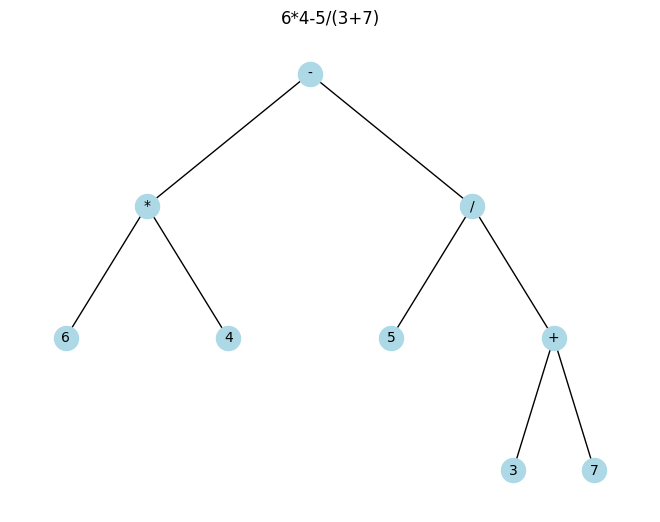

In [14]:
# Create graph and add edges
G = nx.DiGraph()

G.add_node(tree.uid)

label_dict = {tree.uid: tree.token}
add_edges(G, tree, label_dict)

pos = hierarchy_pos(G, tree.uid)
nx.draw(G, pos, labels=label_dict, arrows=False, node_size=300, node_color='lightblue', font_size=10)

plt.title(f'{expr}')
plt.show()